In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
## Read data
import os
print(os.getcwd())

/Users/kunalchakraborty/Downloads/industry_project_HQ


In [4]:
### Load training data
data = pd.read_csv("data/ag_transformed_features.csv")
## Transform date
data["date"] = data["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())

In [5]:
used_features = ["dfy", "infl", "svar", "d/e", "lty", "tms", "tbl", "dfr", "d/p", "d/y", "ltr", "e/p"]
target = ["premium"]

In [6]:
data.set_index("date", inplace=True)

## Fix X and Y

In [12]:
X = data[used_features].copy()
Y = data[target].copy()
#----------------------#
X = X.dropna()
full_datelist = X.index.tolist()
Y = Y[Y.index.isin(full_datelist)]

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

def fix_pred_format(pred_array):
    pred_list = []
    for pred in pred_array:
        pred_list.append(pred[0])
    return pred_list

In [18]:
## Check the rolling window training scheme

### Write a function for rolling model training. Use it for predictions as well
def roll_training(Y,X, datelist, model, model_name, train_rolling_length = 60, forecast_ahead = 1, test_rolling_length = 1, verbose=False):
    """
    Y : Target variable
    X : Training data
    """
    
    predictions = []
    int_start  = 0
    for int_end in range(train_rolling_length, len(datelist)-forecast_ahead, test_rolling_length):
        # Define intervals
        train_interval = datelist[int_start:int_end]
        test_interval = datelist[int_end:int_end+test_rolling_length]
        
        # train interval for yt would be different
        train_interval_y = datelist[int_start+forecast_ahead:int_end+forecast_ahead]
        test_interval_y = datelist[int_end+forecast_ahead:int_end+test_rolling_length+forecast_ahead]
        
        if verbose:
            print("Traing start date = {} and end date = {}".format(min(train_interval), max(train_interval)))
            print("Testing start date = {} and end date = {}".format(min(test_interval), max(test_interval)))
            print("Yt date  = {} and {}".format(min(train_interval_y), max(train_interval_y)))
            print("Prediction Yt date = {} and {} ".format(min(test_interval_y), max(test_interval_y)))
        Yt = Y.loc[train_interval_y]
        Xt = X.loc[train_interval]
        # Testing data
        Xt_test = X.loc[test_interval]
        # Normalize data
        Xt = scaler.fit_transform(Xt)
        Xt_test = scaler.transform(Xt_test)
        
        model.fit(Xt,Yt)
        # Perform prediction
        Yt_pred = model.predict(Xt_test)
        if model_name == "reg":
            # Fix prediction format
            Yt_pred = fix_pred_format(Yt_pred)
        df_temp = pd.DataFrame([test_interval_y, Yt_pred]).T
        df_temp.columns = ["date",model_name]
        predictions.append(df_temp)
        # Update index
        int_start += test_rolling_length
        
    pred_df = pd.concat(predictions)
    pred_df = pred_df.set_index("date")
    return pred_df

In [20]:
def measure_prediction_performance(ypred, yactual, datelist, metric):
    yactual = yactual[yactual.index.isin(datelist)]
    ypred = ypred[ypred.index.isin(datelist)]
    return metric(yactual, ypred)

In [22]:
## Test Rolling regression on RF
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

rf = RandomForestRegressor()

In [19]:
predictions = roll_training(Y,X,full_datelist,rf,"test_rf")

In [23]:
measure_prediction_performance(predictions, Y, predictions.index.tolist(),r2_score)

-0.14986509464892728

### Check R2 score as a function of forecast length

In [25]:
r2score_list = []
for forecast in range(0,13):
    predictions = roll_training(Y,X,full_datelist,rf,"test_rf",forecast_ahead=forecast)
    r2score_list.append(measure_prediction_performance(predictions, Y, predictions.index.tolist(), r2_score))

<BarContainer object of 13 artists>

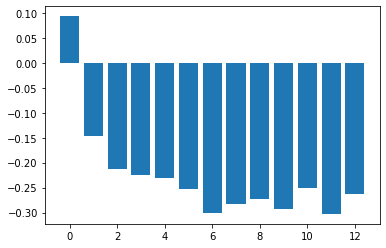

In [26]:
plt.figure()
plt.bar(range(0,13), r2score_list)

In [28]:
## Check this for all the models
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn. ensemble import AdaBoostRegressor

ridge = Ridge(alpha=0.01)
lasso = Lasso(alpha = 2)
lr = LinearRegression()
et = ExtraTreesRegressor(max_depth=3)
gb = GradientBoostingRegressor(max_depth=3)
ada = AdaBoostRegressor()

Text(0.5, 1.0, 'Ridge')

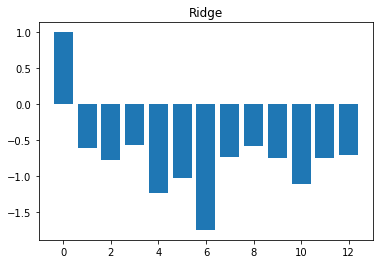

In [29]:
r2score_list = []
for forecast in range(0,13):
    predictions = roll_training(Y,X,full_datelist, ridge,"test_ridge",forecast_ahead=forecast)
    r2score_list.append(measure_prediction_performance(predictions, Y, predictions.index.tolist(), r2_score))
    
plt.figure()
plt.bar(range(0,13), r2score_list)
plt.title("Ridge")

Text(0.5, 1.0, 'Lasso')

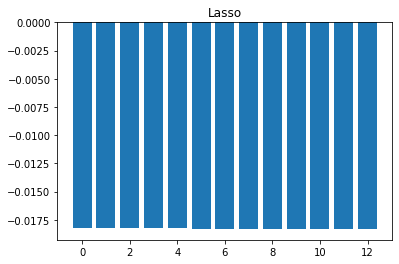

In [30]:
r2score_list = []
for forecast in range(0,13):
    predictions = roll_training(Y,X,full_datelist, lasso,"test_lasso",forecast_ahead=forecast)
    r2score_list.append(measure_prediction_performance(predictions, Y, predictions.index.tolist(), r2_score))
    
plt.figure()
plt.bar(range(0,13), r2score_list)
plt.title("Lasso")

Text(0.5, 1.0, 'Linear regression')

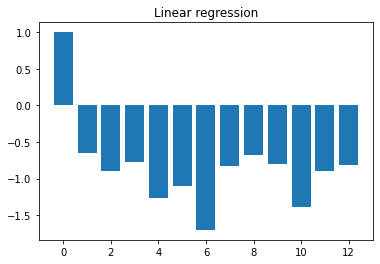

In [31]:
r2score_list = []
for forecast in range(0,13):
    predictions = roll_training(Y,X,full_datelist, lr,"test_lr",forecast_ahead=forecast)
    r2score_list.append(measure_prediction_performance(predictions, Y, predictions.index.tolist(), r2_score))
    
plt.figure()
plt.bar(range(0,13), r2score_list)
plt.title("Linear regression")

Text(0.5, 1.0, 'extra trees')

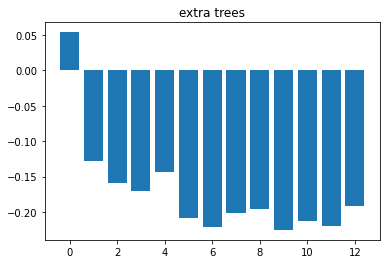

In [32]:
r2score_list = []
for forecast in range(0,13):
    predictions = roll_training(Y,X,full_datelist, et,"test_et",forecast_ahead=forecast)
    r2score_list.append(measure_prediction_performance(predictions, Y, predictions.index.tolist(), r2_score))
    
plt.figure()
plt.bar(range(0,13), r2score_list)
plt.title("extra trees")

Text(0.5, 1.0, 'Gradient boost')

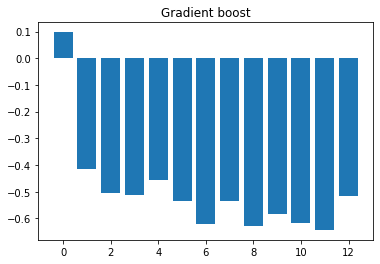

In [33]:
r2score_list = []
for forecast in range(0,13):
    predictions = roll_training(Y,X,full_datelist, gb,"test_gb",forecast_ahead=forecast)
    r2score_list.append(measure_prediction_performance(predictions, Y, predictions.index.tolist(), r2_score))
    
plt.figure()
plt.bar(range(0,13), r2score_list)
plt.title("Gradient boost")

Text(0.5, 1.0, 'Ada boost')

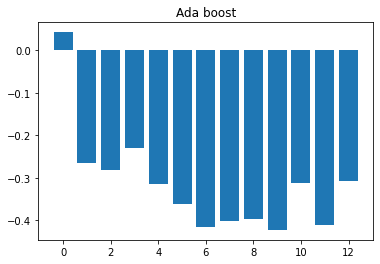

In [34]:
r2score_list = []
for forecast in range(0,13):
    predictions = roll_training(Y,X,full_datelist, ada,"test_ada",forecast_ahead=forecast)
    r2score_list.append(measure_prediction_performance(predictions, Y, predictions.index.tolist(), r2_score))
    
plt.figure()
plt.bar(range(0,13), r2score_list)
plt.title("Ada boost")

### Generate mini - pred df

In [36]:
forecast=1
predictions_ada = roll_training(Y,X,full_datelist, ada,"ada",forecast_ahead=forecast)
predictions_xg = roll_training(Y,X,full_datelist, gb,"gb",forecast_ahead=forecast)
predictions_ridge = roll_training(Y,X,full_datelist, ridge,"ridge",forecast_ahead=forecast)
predictions_lasso = roll_training(Y,X,full_datelist, lasso,"lasso",forecast_ahead=forecast)
predictions_lr = roll_training(Y,X,full_datelist, lr,"lr",forecast_ahead=forecast)
predictions_rf = roll_training(Y,X,full_datelist, rf,"rf",forecast_ahead=forecast)

mini_predictions_df = pd.concat([predictions_ada,predictions_xg,predictions_ridge,predictions_lasso,predictions_lr,
                                predictions_rf], axis=1)

In [38]:
mini_predictions_df["ridge"] = mini_predictions_df["ridge"].apply(lambda x:x[0])
mini_predictions_df["lr"] = mini_predictions_df["lr"].apply(lambda x:x[0])

In [43]:
mini_predictions_df["actuals"] = Y[Y.index.isin(mini_predictions_df.index)]

In [44]:
mini_predictions_df.head()

,ada,gb,ridge,lasso,lr,rf,actuals
date,,,,,,,
1964-03-01,-0.003227,-0.022221,0.009175,0.006755,0.013970,-0.003334,0.014563
1964-04-01,0.005817,0.015173,0.018478,0.006981,0.024423,0.003343,0.005654
1964-05-01,0.008256,-0.012525,0.009564,0.006418,0.010677,0.000263,0.011331
1964-06-01,0.004383,0.009479,0.009216,0.006285,0.003326,0.007608,0.015892
1964-07-01,0.000603,0.009213,0.010681,0.006609,0.011294,0.001426,0.017688


In [46]:
mini_predictions_df.to_csv("data/mini_predictions.csv")